## Import modules

In [1]:
# sklearn
from sklearn.datasets import fetch_openml

import numpy as np

import matplotlib.pyplot as plt

## Loading data

In [2]:
%%time
full_data = fetch_openml("mnist_784")

CPU times: user 16.8 s, sys: 304 ms, total: 17.1 s
Wall time: 17.1 s


In [3]:
full_data.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
full_data['target'].shape

(70000,)

In [5]:
train_size = 60000
test_size = 10000

## Separate full_data to train and test

In [6]:
train_data = {'data': full_data['data'][:train_size], 'target': full_data['target'][:train_size]}
test_data = {'data': full_data['data'][train_size:], 'target': full_data['target'][train_size:]}

## Let's visualize first 10 digits from train:

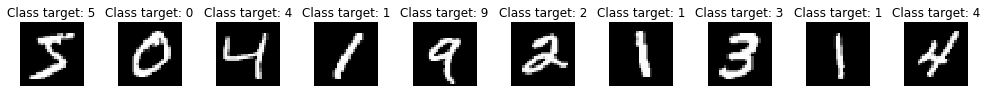

In [7]:
digits_to_show = 10
fig = plt.figure(figsize=(15, 15))
for i in range(digits_to_show):
    ax = fig.add_subplot(1, digits_to_show + 1, i+1)
    ax.imshow(train_data['data'][i].reshape(28, 28), cmap=plt.get_cmap('Greys_r'))
    ax.set_title('Class target: ' + train_data['target'][i])
    ax.axis("off")
plt.tight_layout()
plt.show()

## Testing my KNNClassifier

In [8]:
train_data['target'] = train_data['target'].astype(int)
test_data['target'] = test_data['target'].astype(int)

In [9]:
from sklearn.neighbors import NearestNeighbors
from nearest_neighbors import KNNClassifier
import numpy as np
from distances import euclidean_distance, cosine_distance


n_test_samples = 1000

In [10]:
KNN_model = KNNClassifier(5, strategy='my_own', metric='euclidean', weights=False, test_block_size=44)

In [11]:
%%time
KNN_model.fit(X=train_data['data'][:5000], y=train_data['target'])

CPU times: user 160 µs, sys: 0 ns, total: 160 µs
Wall time: 128 µs


In [12]:
%%time
preds1 = KNN_model.predict(test_data['data'][:n_test_samples])

CPU times: user 7.46 s, sys: 116 ms, total: 7.57 s
Wall time: 957 ms


In [13]:
sum(preds1.astype(int) - test_data['target'][:n_test_samples].astype(int) == 0) / test_data['target'][:n_test_samples].size

0.91

## Testing distances

In [14]:
import numpy as np
from distances import euclidean_distance, cosine_distance

In [15]:
x = np.array([[2, 3], [-1, 6], [10, 22]])
y = np.array([[1, 1], [-1, 2]])

In [16]:
cosine_distance(x, y)

array([[0.01941932, 0.50386106],
       [0.41876181, 0.04422099],
       [0.06367082, 0.37080177]])

In [17]:
%load_ext memory_profiler

In [18]:
%%time
%%memit
X = np.ones((2000, 1000)) * 5
print(euclidean_distance(np.ones((2000, 1000)) * 5, np.ones((500, 1000))))
#2.22 s - new on 200x500

#763 ms - old on 200x500
#7725.48 


[[126.49110641 126.49110641 126.49110641 ... 126.49110641 126.49110641
  126.49110641]
 [126.49110641 126.49110641 126.49110641 ... 126.49110641 126.49110641
  126.49110641]
 [126.49110641 126.49110641 126.49110641 ... 126.49110641 126.49110641
  126.49110641]
 ...
 [126.49110641 126.49110641 126.49110641 ... 126.49110641 126.49110641
  126.49110641]
 [126.49110641 126.49110641 126.49110641 ... 126.49110641 126.49110641
  126.49110641]
 [126.49110641 126.49110641 126.49110641 ... 126.49110641 126.49110641
  126.49110641]]
[[126.49110641 126.49110641 126.49110641 ... 126.49110641 126.49110641
  126.49110641]
 [126.49110641 126.49110641 126.49110641 ... 126.49110641 126.49110641
  126.49110641]
 [126.49110641 126.49110641 126.49110641 ... 126.49110641 126.49110641
  126.49110641]
 ...
 [126.49110641 126.49110641 126.49110641 ... 126.49110641 126.49110641
  126.49110641]
 [126.49110641 126.49110641 126.49110641 ... 126.49110641 126.49110641
  126.49110641]
 [126.49110641 126.49110641 126.

In [19]:
%%time
std_norm = np.linalg.norm(X, axis=1)
print('done')

done
CPU times: user 21.1 ms, sys: 287 µs, total: 21.4 ms
Wall time: 2.38 ms


In [20]:
%%time
my_norm = np.sqrt(np.sum(X ** 2, axis=1))
print('done')

done
CPU times: user 20.3 ms, sys: 0 ns, total: 20.3 ms
Wall time: 2.41 ms


In [21]:
sum(std_norm != my_norm)

0

## Testing cross_validation

In [115]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


def euclidean_distance(X, Y):
    """
    params:
        * X - np.array with size N x D
        * Y - np.array with size M x D
    return values:
        * np.array with size N x M, where [i, j] - euclidean distance between i-th vector from X and
                                                                              j-th vector from Y
    """

    X_sqr = np.sum(X ** 2, axis=1)[:, None]
    Y_sqr = np.sum(Y ** 2, axis=1)
    return np.sqrt(X_sqr - 2 * np.dot(X, Y.T) + Y_sqr)


def cosine_distance(X, Y):
    """
    params:
        * X - np.array with size N x D
        * Y - np.array with size M x D
    return values:
        * np.array with size N x M, where [i, j] - cosine distance between i-th vector from X and
                                                                              j-th vector from Y
    """

    result = np.dot(X, Y.T)
    result = result / np.sqrt(np.sum(X ** 2, axis=1))[:, None]
    result = result / np.sqrt(np.sum(Y ** 2, axis=1))
    return 1 - result


class KNNClassifier:
    def __init__(self,
                 k=10,
                 strategy='my_own',
                 metric='euclidean',
                 weights=False,
                 test_block_size=10000
                 ):
        """
        params:
            * k - amount of nearest neighbours(nn)
            * strategy - nn searching algorithm. Possible values:
                - 'my_own' - self-realization
                - 'brute' - from sklearn.neighbors.NearestNeighbors(algorithm='brute')
                - 'kd_tree' - from sklearn.neighbors.NearestNeighbors(algorithm='kd_tree')
                - 'ball_tree' - from sklearn.neighbors.NearestNeighbors(algorithm='ball_tree')
            * metric:
                - 'euclidean' - euclidean metric
                - 'cosine' - cosine metric
            * weights - bool variable.
                - True - weighted KNN(with distance)
                - False - simple KNN
            * test_block_size - size of test block
        """

        self.X_train = None
        self.y_train = None
        self.distances = None
        self.neigh_idxs = None
        self.model = None
        self.k = k
        self.strategy = strategy
        self.metric = metric
        self.eps = 1e-5
        self.weights = weights
        if self.strategy == 'brute':
            self.model = NearestNeighbors(n_neighbors=self.k, algorithm=self.strategy, metric=self.metric)
        elif self.strategy != 'my_own':
            self.model = NearestNeighbors(n_neighbors=self.k, algorithm=self.strategy)
        else:
            self.model = None
        self.test_block_size = test_block_size

    def fit(self, X, y):
        """
        params:
            * X - train data
            * y - targets for train data
        """

        self.y_train = y.astype(int)
        self.k = np.min([self.y_train.shape[0], self.k])
        if self.strategy != 'my_own':
            self.model.fit(X, self.y_train)
        else:
            self.X_train = X

    def find_kneighbors(self, X, return_distance):
        """
        params:
            * X - objects sample
            * return_distance - bool variable

        return values:
            * If return_distance == True:
                * tuple with two numpy array with size (X.shape[0], k), where:
                  [i, j] elem of first array must be the distance between
                  i-th object and his j-th nearest neighbour
                  [i, j] elem of second array must be the index of j-th nearest neighbour to i-th object
            * If return_distance == False:
                * only second array
        """

        if self.strategy != 'my_own':
            self.distances, \
            self.neigh_idxs = self.model.kneighbors(X, n_neighbors=self.k)
        else:
            if self.metric == 'euclidean':
                self.distances = euclidean_distance(X, self.X_train)
                self.neigh_idxs = np.argsort(self.distances,
                                        axis=1)[:, :self.k]
                if return_distance:
                    self.distances = np.sort(self.distances,
                                        axis=1)[:, :self.k]

            elif self.metric == 'cosine':
                self.distances = cosine_distance(X, self.X_train)
                self.neigh_idxs = np.argsort(self.distances,
                                        axis=1)[:, :self.k]
                if return_distance:
                    self.distances = np.sort(self.distances,
                                        axis=1)[:, :self.k]
        if return_distance:
            return self.distances, self.neigh_idxs
        return self.neigh_idxs

    def predict(self, X):
        """
        params:
            * X - test objects

        return values:
            * numpy array with size X.shape[0] of predictions for test objects from X
        """

        if self.test_block_size > X.shape[0]:
            self.test_block_size = X.shape[0]
        preds = np.zeros(X.shape[0])
        split_size = X.shape[0] // self.test_block_size + \
                     int(X.shape[0] % self.test_block_size != 0)
        curr_idx = 0
        classes = np.array(np.unique(self.y_train))
        for i, split in enumerate(np.array_split(X, split_size)):
            self.distances, self.neigh_idxs = self.find_kneighbors(split, True)
            for j, idx in enumerate(self.neigh_idxs):
                counts = np.zeros(len(classes))
                for c in classes:
                    if self.weights:
                        weights = 1 / (self.distances[j] + self.eps)
                        counts[c] = np.sum((self.y_train[idx] == c) * weights)
                    else:
                        counts[c] = np.sum(self.y_train[idx] == c)
                preds[j + curr_idx] = np.argmax(counts)
            curr_idx += split.shape[0]
        return preds

    def predict_for_cv(self, X):
        """
        params:
            * X - test objects

        return values:

        """

        preds = np.zeros(X.shape[0])
        classes = np.array(np.unique(self.y_train))
        for j, idx in enumerate(self.neigh_idxs[:, :self.k]):
            counts = np.zeros(len(classes))
            for c in classes:
                if self.weights:
                    weights = 1 / (self.distances[j, :self.k] + self.eps)
                    counts[c] = np.sum((self.y_train[idx] == c) * weights)
                else:
                    counts[c] = np.sum(self.y_train[idx] == c)
            preds[j] = np.argmax(counts)
        return preds


def kfold(n, n_folds=3):
    """
    params:
        * n - objects amount in sample
        * n_folds - folds amount
    return values:
        * list with size n_folds, where every element is tuple of two 1D numpy array:
            * first array contains indices of train samples
            * second array contains indices of validation samples
    """

    indices = np.arange(n)
    size_of_one_fold = int(n / n_folds) + (n < n_folds)
    size_with_folds = size_of_one_fold * n_folds
    out_elements_amount = len(indices) - size_with_folds
    train_test_idx_list = []
    for i in range(n_folds):
        test_idx = indices[i * size_of_one_fold:(i + 1) * size_of_one_fold]
        if out_elements_amount > 0:
            test_idx = np.append(test_idx, n - out_elements_amount)
            out_elements_amount -= 1
        train_idx = np.array(list((set(indices) - set(test_idx))))
        train_test_idx_list.append((train_idx, test_idx))
    return train_test_idx_list


def accuracy(y_valid, y_true):
    return np.sum(y_valid == y_true, axis=0) / len(y_valid) * 100


def knn_cross_val_score(X, y, k_list, score='accuracy', cv=None, **kwargs):
    """
    :param X: train samples
    :param y: targets for train
    :param k_list: list of values of neighbors amount, in ascending order
    :param score: metric name( accuracy' must have)
    :param cv: list of tuples, which contains indices of train and valid samples
    :param kwargs: parameters for __init__ from KNNClassifier
    :return: dict, where keys is neigbors amount from k_list, values - numpy array of size len(cv)
    with accuracy on each fold
    """

    if cv is None:
        cv = kfold(X.shape[0])
    knn = None
    if 'k' not in kwargs.keys():
        knn = KNNClassifier(k_list[-1], **kwargs)
    else:
        knn = KNNClassifier(**kwargs)
    accuracy_per_k = {k: np.empty(0) for k in k_list}
    for fold in cv:
        knn.k = k_list[-1]
        knn.fit(X[fold[0]], y[fold[0]])
        knn.find_kneighbors(X[fold[1]], return_distance=True)
        for k in k_list:
            knn.k = k
            y_valid = knn.predict_for_cv(X[fold[1]])
            accuracy_per_k[k] = np.append(accuracy_per_k[k],
                                          accuracy(y_valid,
                                                   y[fold[1]]))
    return accuracy_per_k


In [116]:
%%time

knn_cross_val_score(train_data['data'][:1000],
                    train_data['target'][:1000],
                    k_list=[3, 5, 15, 20, 25, 50, 100, 250, 500],
                    score='accuracy',
                    cv=None,
                    k=5,
                    strategy='brute',
                    metric='euclidean',
                    weights=False,
                    test_block_size=1000
                   )

CPU times: user 4.24 s, sys: 75.8 ms, total: 4.31 s
Wall time: 542 ms


{3: array([86. , 84.5, 85. , 80.5, 89. ]),
 5: array([87., 85., 86., 81., 87.]),
 15: array([84. , 83.5, 81. , 75. , 82. ]),
 20: array([80. , 83.5, 81.5, 75. , 82.5]),
 25: array([80. , 82.5, 80. , 72.5, 81.5]),
 50: array([74. , 80. , 73.5, 68.5, 79. ]),
 100: array([68., 72., 66., 61., 65.]),
 250: array([52. , 52. , 46.5, 48.5, 44.5]),
 500: array([28.5, 35. , 28. , 23. , 23. ])}

In [121]:
knn_test = KNNClassifier(
                    k=500,
                    strategy='brute',
                    metric='euclidean',
                    weights=False,
                    test_block_size=1000)
knn_test.fit(train_data['data'][:800], train_data['target'][:800])

In [120]:
%%time
preds1 = knn_test.predict(train_data['data'][800:1000])

sum(preds1.astype(int) - train_data['target'][800:1000].astype(int) == 0) / train_data['target'][800:1000].size

CPU times: user 232 ms, sys: 12.4 ms, total: 245 ms
Wall time: 32.7 ms


0.23

In [122]:
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
knn_true = KNeighborsClassifier(5, algorithm='brute', weights='uniform', metric='euclidean')
knn_true.fit(train_data['data'][:800], train_data['target'][:800])

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [111]:
preds1 = knn_true.predict(train_data['data'][800:1000])

sum(preds1.astype(int) - train_data['target'][800:1000].astype(int) == 0) / train_data['target'][800:1000].size

0.87

In [90]:
cross_val_score(knn, train_data['data'][:1000], train_data['target'][:1000], cv=3)

array([0.82142857, 0.82582583, 0.80362538])

## Experiments list

### Experiment №1

In [123]:
from sklearn.neighbors import NearestNeighbors
from nearest_neighbors import KNNClassifier
import numpy as np
from distances import euclidean_distance, cosine_distance
from tqdm import tqdm
import time
import pandas as pd


strategy_list = ['my_own', 'brute', 'kd_tree', 'ball_tree']
feature_dim_list = [10, 20, 100]
k_neighbors = 5

experiment1_results = pd.DataFrame(columns=['strategy', 'feature_dim', 'time_elapsed'])

for feature_dim in tqdm(feature_dim_list):
    features_idxs = np.random.choice(test_data['data'].shape[1],
                                     feature_dim,
                                     replace=False)
    for strategy in tqdm(strategy_list):
        knn = KNNClassifier(k_neighbors,
                            strategy)
        knn.fit(train_data['data'][:, features_idxs],
                train_data['target'])
        start = time.time()
        knn.find_kneighbors(test_data['data'][:, features_idxs], True)
        time_elapsed = time.time() - start
        experiment1_results = \
            experiment1_results.append({'feature_dim': feature_dim,
                                        'strategy': strategy,
                                        'time_elapsed': time_elapsed},
                                       ignore_index=True)
        
        
        

100%|██████████| 3/3 [07:29<00:00, 141.98s/it][A


In [124]:
experiment1_results

,strategy,feature_dim,time_elapsed
0,my_own,10,68.074046
1,brute,10,7.844289
2,kd_tree,10,0.441361
3,ball_tree,10,1.720195
4,my_own,20,76.828881
5,brute,20,7.959555
6,kd_tree,20,1.405176
7,ball_tree,20,6.638407
8,my_own,100,78.310371
9,brute,100,8.280682


In [126]:
experiment1_results.to_csv('experiment1_results.csv')

### Experiment №2

In [11]:
%load_ext autoreload
%autoreload 2

In [21]:
from sklearn.neighbors import NearestNeighbors
from nearest_neighbors import KNNClassifier
from cross_validation import *
import numpy as np
from distances import euclidean_distance, cosine_distance
from tqdm import tqdm
import time
import pandas as pd


n_folds = 3
k_list = [k for k in range(1, 11)]
metric_list = ['euclidean', 'cosine']

experiment2_results = pd.DataFrame(columns=['k_neighbors', 'metric', 'accuracy', 'elapsed_time'])


for metric in tqdm(metric_list):
    start = time.time()
    preds_dict = knn_cross_val_score(train_data['data'],
                                     train_data['target'],
                                     k_list=k_list,
                                     score='accuracy',
                                     k=k_list[-1],
                                     strategy='brute',
                                     metric=metric,
                                     weights=False
                                    )
    time_elapsed = time.time() - start
    for k in k_list:
        experiment2_results = \
            experiment2_results.append({'k_neighbors': k,
                                        'metric': metric,
                                        'accuracy': preds_dict[k],
                                        'elapsed_time': time_elapsed},
                                        ignore_index=True
                                      )
        
        

100%|██████████| 2/2 [03:25<00:00, 102.91s/it]


In [22]:
experiment2_results

,k_neighbors,metric,accuracy,elapsed_time
0,1,euclidean,"[96.895, 96.675, 96.67]",103.422209
1,2,euclidean,"[96.03, 95.99499999999999, 96.125]",103.422209
2,3,euclidean,"[96.955, 96.825, 96.71499999999999]",103.422209
3,4,euclidean,"[96.705, 96.67, 96.71]",103.422209
4,5,euclidean,"[96.81, 96.73, 96.72]",103.422209
5,6,euclidean,"[96.555, 96.495, 96.57]",103.422209
6,7,euclidean,"[96.52, 96.5, 96.56]",103.422209
7,8,euclidean,"[96.41499999999999, 96.39, 96.525]",103.422209
8,9,euclidean,"[96.37, 96.32, 96.455]",103.422209
9,10,euclidean,"[96.245, 96.22, 96.37]",103.422209


In [23]:
experiment2_results.to_csv('experiment2_results')

## Experiment №3

In [29]:
from sklearn.neighbors import NearestNeighbors
from nearest_neighbors import KNNClassifier
from cross_validation import *
import numpy as np
from distances import euclidean_distance, cosine_distance
from tqdm import tqdm
import time
import pandas as pd


n_folds = 3
k_list = [k for k in range(1, 11)]
metric_list = ['euclidean', 'cosine']
strategy_list = ['my_own', 'brute', 'kd_tree', 'ball_tree']
weight_list = [False, True]

experiment3_results = pd.DataFrame(columns=['k_neighbors',
                                            'metric',
                                            'strategy',
                                            'weights',
                                            'accuracy',
                                            'elapsed_time']
                                  )

for weight in tqdm(weight_list):
    for metric in tqdm(metric_list):
        for strategy in tqdm(strategy_list):
            start = time.time()
            preds_dict = knn_cross_val_score(train_data['data'],
                                             train_data['target'],
                                             k_list=k_list,
                                             score='accuracy',
                                             k=k_list[-1],
                                             strategy=strategy,
                                             metric=metric,
                                             weights=weight
                                            )
            time_elapsed = time.time() - start
            for k in k_list:
                experiment3_results = \
                    experiment3_results.append({'k_neighbors': k,
                                                'metric': metric,
                                                'strategy': strategy,
                                                'weights': weight,
                                                'accuracy': preds_dict[k],
                                                'elapsed_time': time_elapsed},
                                                ignore_index=True
                                              )
            





  0%|          | 0/2 [00:00<?, ?it/s]



  0%|          | 0/2 [00:00<?, ?it/s]




  0%|          | 0/4 [00:00<?, ?it/s]




 25%|██▌       | 1/4 [06:03<18:11, 363.81s/it]




 50%|█████     | 2/4 [07:46<09:31, 285.57s/it]




 75%|███████▌  | 3/4 [43:32<14:03, 843.70s/it]




100%|██████████| 4/4 [1:09:39<00:00, 1060.55s/it]



 50%|█████     | 1/2 [1:09:39<1:09:39, 4179.37s/it]




  0%|          | 0/4 [00:00<?, ?it/s]




 25%|██▌       | 1/4 [06:02<18:06, 362.22s/it]




 50%|█████     | 2/4 [07:43<09:27, 283.85s/it]




 75%|███████▌  | 3/4 [43:20<13:59, 839.96s/it]




100%|██████████| 4/4 [1:09:18<00:00, 1055.39s/it]



100%|██████████| 2/2 [2:18:58<00:00, 4173.20s/it]  


 50%|█████     | 1/2 [2:18:58<2:18:58, 8338.17s/it]



  0%|          | 0/2 [00:00<?, ?it/s]




  0%|          | 0/4 [00:00<?, ?it/s]




 25%|██▌       | 1/4 [06:23<19:10, 383.57s/it]




 50%|█████     | 2/4 [08:28<10:11, 305.86s/it]




 75%|███████▌  | 3/4 [44:27<14:21, 861.81s/it]




100%|██████████|

In [40]:
experiment3_results.to_csv('experiment3_results.csv')

In [55]:
experiment3_results['mean_accuracy'] = experiment3_results['accuracy'].map(np.mean)

## Best algorithm params by accuracy:

In [67]:
best_model_params_idx = experiment3_results.sort_values(by='mean_accuracy', ascending=False).index[0]

In [68]:
best_model_params = experiment3_results.loc[best_model_params_idx]

In [69]:
best_model_params

k_neighbors                            4
metric                            cosine
strategy                          my_own
accuracy         [97.545, 97.32, 97.365]
elapsed_time                     383.728
weight                                 1
mean_accuracy                      97.41
Name: 123, dtype: object

## Experiment №4

In [71]:
knn_best = KNNClassifier(k=best_model_params['k_neighbors'],
                         metric=best_model_params['metric'],
                         strategy=best_model_params['strategy'],
                         weights=best_model_params['weight']
                        )

In [73]:
knn_best.fit(train_data['data'],
             train_data['target']
            )

In [75]:
preds = knn_best.predict(test_data['data'])

In [78]:
print('Total accuracy on test: ', accuracy(preds, test_data['target']))

Total accuracy on test:  0.9752


В статье https://arxiv.org/pdf/1809.06846.pdf авторы смогли достичь точности в 0.9714 при 3 соседей без модификаций, 0.9773 при использовании скользящего окна(подробности по ссылке)
Тут https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html написано, что авторам удалось добиться точности = 0.9979 с помощью нейронных сетей.

In [81]:
from sklearn.metrics import confusion_matrix


In [87]:
conf_matrix = confusion_matrix(preds, test_data['target'], labels=np.unique(test_data['target']))

In [93]:
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

In [94]:
#from sklearn documentation

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 977    0    8    0    2    4    3    2    7    7]
 [   1 1129    0    1    1    0    3   10    1    7]
 [   0    3 1009    3    0    0    0    4    2    2]
 [   0    1    1  976    0    9    0    0    9    5]
 [   0    0    1    1  946    1    1    1    3    7]
 [   0    0    0   12    0  863    3    0    3    3]
 [   1    2    0    0    6    7  948    0    5    1]
 [   1    0    8    4    2    1    0  998    4    4]
 [   0    0    5    9    0    4    0    0  936    3]
 [   0    0    0    4   25    3    0   13    4  970]]


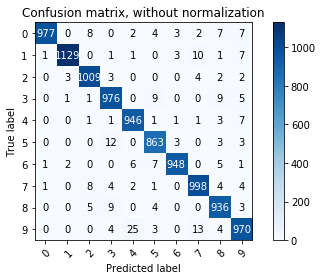

In [98]:
plot_confusion_matrix(preds.astype(int), test_data['target'].astype(int), classes=np.unique(test_data['target']))
plt.show()

In [103]:
indexes_with_errors = np.where(preds != test_data['target'])

## Попробуем визуализировать некоторые объекты с ошибками:

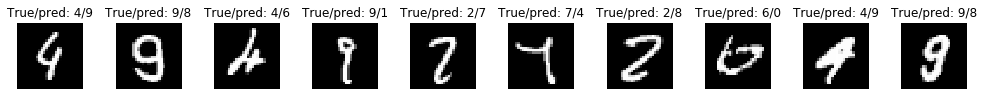

In [117]:
digits_to_show = 10
fig = plt.figure(figsize=(15, 15))
for i in range(digits_to_show):
    ax = fig.add_subplot(1, digits_to_show + 1, i+1)
    ax.imshow(test_data['data'][indexes_with_errors[0][i]].reshape(28, 28), cmap=plt.get_cmap('Greys_r'))
    ax.set_title('True/pred: ' + test_data['target'][indexes_with_errors[0][i]].astype(str) + '/' + \
                 preds[indexes_with_errors[0][i]].astype(int).astype(str))
    ax.axis("off")
plt.tight_layout()
plt.show()

В большинстве случаев видно, что написаннные цифры немного деформированы и похожи на другие в некоторых чертах